In [1]:
import numpy as np
import sys
sys.path.append('/home/cayjobla/Desktop/Research/delay-optimizer')
from DelayEffects.Analyzer import Analyzer
import os
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib
from delay_types import undelayed, uniform, stochastic, decaying, partial, parse_delay_type

In [2]:
# Initialize
loss_name = 'Ackley'
ackley2d = Analyzer(2, loss_name)
ackley10d = Analyzer(10, loss_name)
ackley100d = Analyzer(100, loss_name)
ackley1000d = Analyzer(1000, loss_name)
ackley10000d = Analyzer(10000, loss_name)

## 2 dimensional stochastic delayed test

In [3]:
plots = [(True, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', True, plots, time_plot=False, contour_plot=False, colorbar=True, random=True)

KeyboardInterrupt: 

## 2 dimensional 100% delayed test

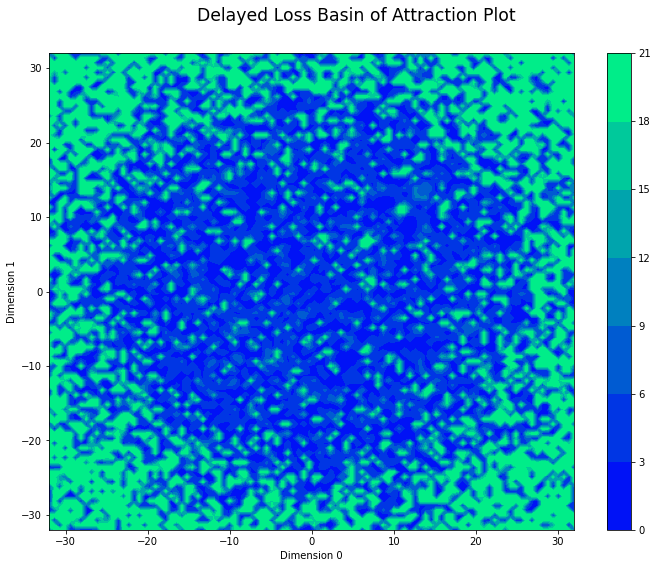

Minimum Delayed Loss: 0.2135743487449493
Mean Delayed Loss: 9.053883600842148
Median Delayed Loss: 4.884065265863555


In [9]:
D_s = np.ones(2,dtype=int)
D = [D_s]
plots = [(True, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', True, plots, time_plot=False, contour_plot=False, colorbar=True, random=False, D=D)

## 2 dimensional 50% delayed test

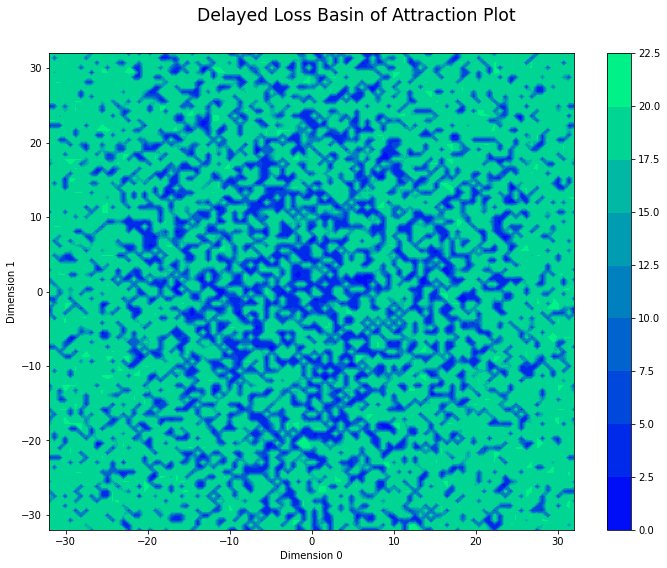

Minimum Delayed Loss: 0.20345719460694456
Mean Delayed Loss: 14.086782877784001
Median Delayed Loss: 19.867373388949634


In [7]:
D_s = np.zeros(2,dtype=int)
D_s[0] = 1
D = [D_s]
plots = [(True, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', True, plots, time_plot=False, contour_plot=False, colorbar=True, random=False, D=D)

## 2 dimensional undelayed test

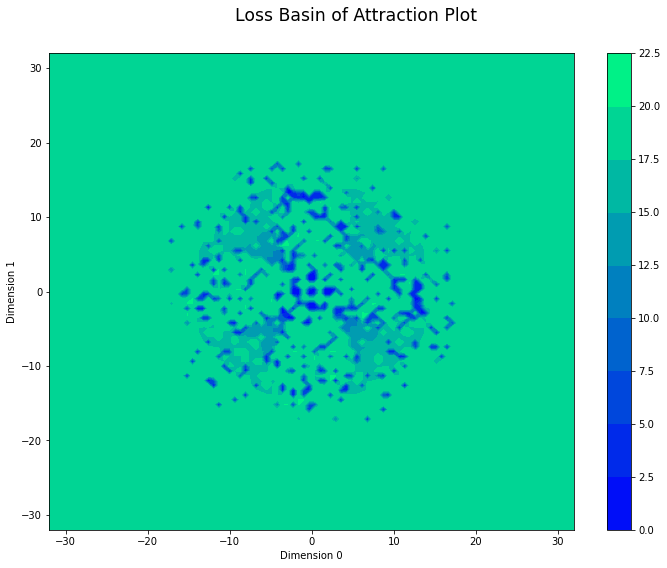

Minimum Loss: 0.16819041018336067
Mean Loss: 18.632774961440457
Median Loss: 19.60685273253687


In [8]:
plots = [(False, 'basin', 'loss')]
ackley2d.optimize(100, 'grid', False, plots, time_plot=False, contour_plot=False, colorbar=True, random=True)

In [15]:
def chaos_test(analyzer, eps=1e-5, max_L=1, num_points=1, given=None, num_delays=1000):
    # Initialize
    n = analyzer.n
    low, high = analyzer.range_grid

    # Set or unpack initial values
    if given is None:
        x_init = np.random.uniform(low, high, size=(1,n))
        x_init_err = x_init + np.random.uniform(-eps,eps,(num_points,n))
        x_inits = np.vstack((x_init, x_init_err))
    else:
        x_inits = given

    print(x_init)
    # Find paths constant
    analyzer.optimize(1, 'given', True, plots=[[True, 'path', 'loss']], points=x_inits, 
                      max_L=max_L, D=[np.ones(n, dtype=int)], random=False, time_plot=True, 
                      clear_data=False, num_delays=num_delays, break_opt=False)

    # Plot the error over time
    fig = plt.figure(figsize=(10,8))
    for i in range(1,num_points):
        x1 = analyzer.del_time_series[0]
        x2 = analyzer.del_time_series[i]
        plt.semilogy(np.linalg.norm(x1 - x2, axis=1), 'C1', alpha=0.25)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.title("Error of closely spaced points over time")
    plt.show()
    
    analyzer.clear()

In [5]:
def plot_convergence(analyzer, num_points, plot_dims=[(0,1)], grid=False, cut=0, delayed=True):
    """Plot the path of points as they converge to the minimum"""
    if grid is True:
        sample = 'grid'
    else:
        sample = 'random'
        
    analyzer.initialize_points(num_points, sample)
    analyzer.calculate_save_values(delayed, break_opt=False)
    # Initialize for the graph
    num_plots = len(plot_dims)
    fig, ax = plt.subplots(num_plots, 1, figsize=(10,8*(num_plots)))
    if type(ax) is not np.ndarray:
        ax = np.array([ax])
    alpha = 0.01
            
    for j in range(num_plots):
        axis = ax[j]
        dim_tuple = plot_dims[j]
        for i in range(len(analyzer.x_inits)):
            data = analyzer.extract_dims(i, dim_tuple, delayed)
            im = axis.scatter(data[0][cut:], data[1][cut:], color='r', alpha=0.1, s=0.1)
        axis.set_xlabel("Dimension {}".format(dim_tuple[0]))
        axis.set_ylabel("Dimension {}".format(dim_tuple[1]))
        axis.set_xlim(analyzer.range_grid)
        axis.set_ylim(analyzer.range_grid)
        
    plt.show()

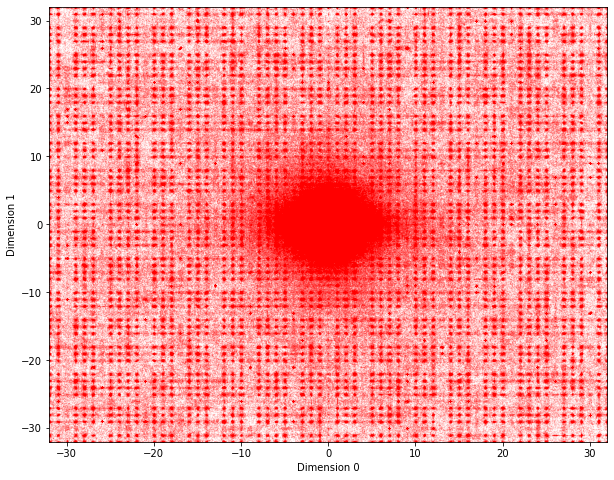

In [10]:
plot_convergence(ackley2d, 50, grid=True, cut=0)

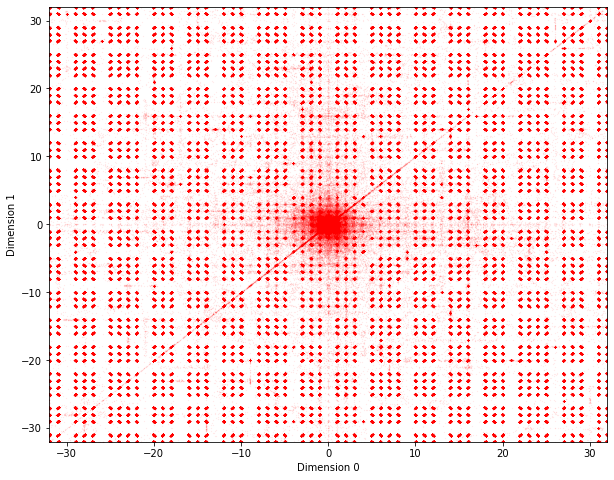

In [9]:
plot_convergence(ackley2d, 50, grid=True, cut=0, delayed=False)

In [ ]:
plot_convergence(ackley10d, 50, grid=True, cut=0)

In [ ]:
plot_convergence(ackley10d, 50, grid=True, cut=0, delayed=False)

# Scatterplot Convergence Stochastic

In [7]:
ackley2d.initialize_points(500, 'random')
ackley2d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

In [8]:
ackley2d.plot_results(False, 'path', 'loss', time_plot=[0])
ackley2d.plot_results(True, 'path', 'loss', time_plot=[0], cmap2='winter_r')

NameError: name 'ackley2d' is not defined

In [4]:
ackley10d.initialize_points(500, 'random')
ackley10d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

In [7]:
rand_dims = np.random.choice(np.arange(10), size=2, replace=False)
ackley10d.plot_list([(False, 'path', 'loss'),(True, 'path', 'loss'),('both', 'finals', 'iters')], 
                    plot_dims=[rand_dims], time_plot=[0], cmap2='winter_r')

NameError: name 'np' is not defined

In [8]:
ackley100d.initialize_points(500, 'random')
ackley100d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

In [6]:
rand_dims = np.random.choice(np.arange(100), size=2, replace=False)
ackley100d.plot_list([(False, 'path', 'loss'),(True, 'path', 'loss'),('both', 'finals', 'iters')], 
                     plot_dims=[rand_dims], time_plot=[0], cmap2='winter_r')

NameError: name 'np' is not defined

In [10]:
ackley1000d.initialize_points(500, 'random')
ackley1000d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

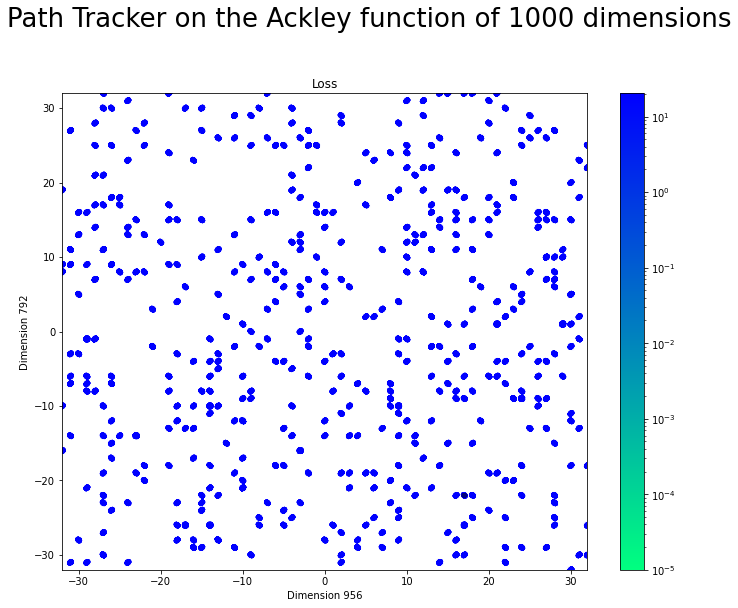

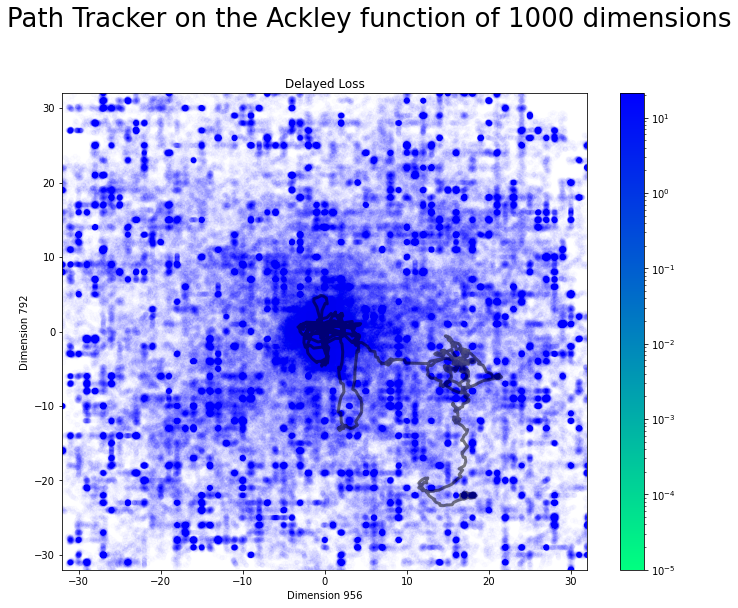

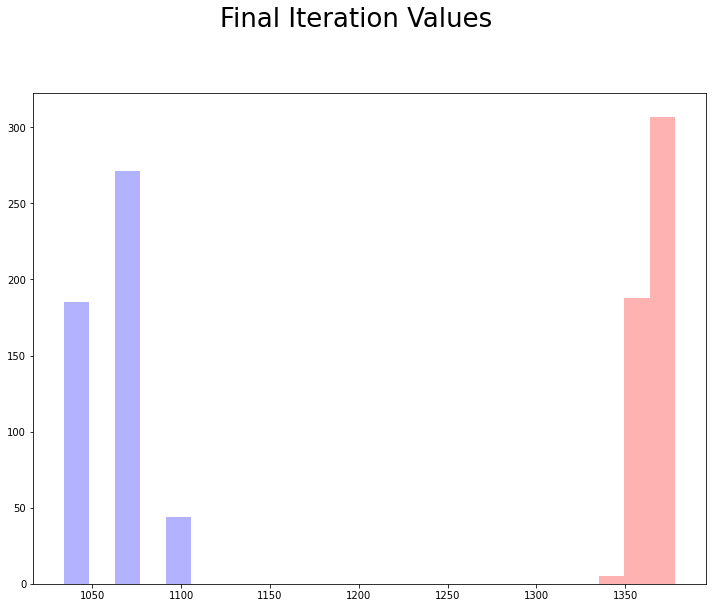

In [11]:
rand_dims = np.random.choice(np.arange(1000), size=2, replace=False)
ackley1000d.plot_list([(False, 'path', 'loss'),(True, 'path', 'loss'),('both', 'finals', 'iters')], 
                      plot_dims=[rand_dims], time_plot=[0], cmap2='winter_r')

# Loss Visualization

In [3]:
filename = 'ackley2dgrid100.pkl'
if os.path.exists(filename):
    ackley2d.load_vals(filename)
else:
    num_points = 100
    ackley2d.optimize(num_points, 'grid', 'both', break_opt=True, 
                     print_loss=False, clear_data=False, 
                     save_grad=False, save_iters=False)
    # Save as pickle so we don't need to again
    ackley2d.save_vals(filename)

In [3]:
%matplotlib notebook

In [4]:
f = ackley2d.loss
x_inits, (X, Y) = ackley2d.create_grid(500)
Z = np.array([f(x) for x in x_inits]).reshape((500,500))
vmax = max([np.max(loss) for loss in Z.ravel()])
vmin = 0

<IPython.core.display.Javascript object>


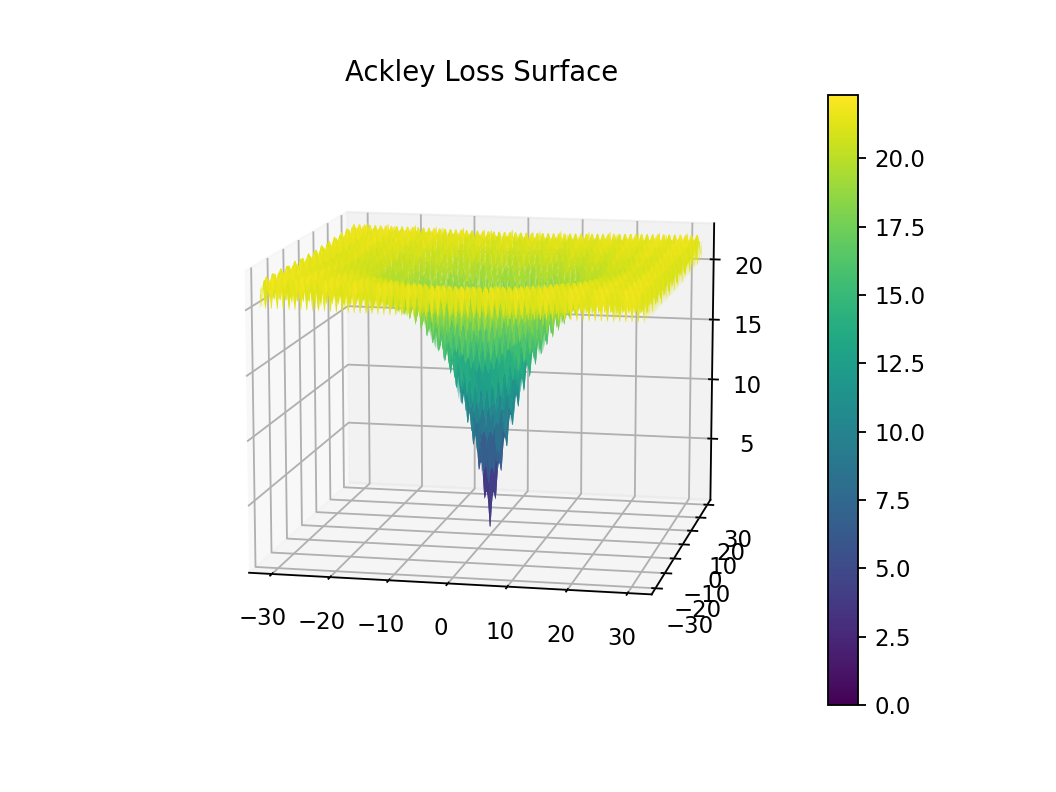

In [14]:
fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d') 
surf = ax.plot_surface(X, Y, Z, cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_xlim(ackley2d.range_grid)
ax.set_ylim(ackley2d.range_grid)
plt.title("Ackley Loss Surface")
ackley2d.plot_colorbar(fig, ax, surf)
plt.savefig("ack_loss_colorbar.png")
plt.show()

In [5]:
# Initialize
num_plots = 1
num_points = len(ackley2d.x_inits)
X, Y = ackley2d.grid
include_exteriors = True
bounds = ackley2d.range_grid

fig = plt.figure(dpi=150)
ax = plt.axes(projection='3d')   

# Extract loss values
loss_vals, _ = ackley2d.extract_values(False, 'loss')
del_loss_vals, _ = ackley2d.extract_values(True, 'loss')

# Get initial loss surface values
Z_init = np.zeros(num_points)
for i in range(num_points):
    Z_init[i] = loss_vals[i][0]
Z_init = np.resize(Z_init, (len(X),len(Y))).T
vmax = max([np.max(point) for point in Z_init.ravel()])
vmin = 0

# Plot the loss surface
surf = ax.plot_surface(X, Y, Z_init, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
plt.colorbar(surf, ax=ax, pad=0.2)

ax.set_xlim(bounds)
ax.set_ylim(bounds)
plt.show()

NameError: name 'ackley2d' is not defined

In [4]:
# Initialize
num_points = len(ackley2d.x_inits)
X, Y = ackley2d.grid
bounds = ackley2d.range_grid

# Initialize the plot and set attributes
fig = plt.figure(dpi=150, figsize=(12,4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

vmax= max([np.max(point) for point in Z_init.ravel()])
zlim = [0, vmax]

# Create the initialization function
def init():    
    # Set limits
    surf1 = ax1.plot_surface(X, Y, Z_init, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
    ax1.set_xlim(bounds)
    ax1.set_ylim(bounds)
    ax1.set_zlim(zlim)
    ax1.set_title("Undelayed")
    
    surf2 = ax2.plot_surface(X, Y, Z_init, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax)
    ax2.set_xlim(bounds)
    ax2.set_ylim(bounds)
    ax2.set_zlim(zlim)
    ax2.set_title("Stochastic Delays")
    
    plt.colorbar(surf1, ax=ax1, pad=0.2)
    plt.colorbar(surf2, ax=ax2, pad=0.2)


# Create the update function
def update(i):
    ax1.clear()     # Clear the previous frame
    ax2.clear()
    
    # Get delayed and undelayed loss values
    Z, del_Z = np.zeros_like(Z_init.ravel()), np.zeros_like(Z_init.ravel())
    for j in range(num_points):
        if i < len(loss_vals[j]):
            Z[j] = loss_vals[j][i]
        else:
            Z[j] = ackley2d.final_losses[j]
        if i < len(del_loss_vals[j]):
            del_Z[j] = del_loss_vals[j][i]
        else:
            del_Z[j] = ackley2d.del_final_losses[j]
            
    # Get largest loss value
    vmax = max([np.max(point) for point in np.hstack([Z, del_Z]).ravel()])
    zlim = [0, vmax]
            
    Z = np.resize(Z, (len(X),len(Y))).T
    del_Z = np.resize(del_Z, (len(X),len(Y))).T
    
    # Set limits
    surf1 = ax1.plot_surface(X, Y, Z, cmap=plt.cm.cividis, vmin=vmin, vmax=vmax)
    ax1.set_xlim(bounds)
    ax1.set_ylim(bounds)
    ax1.set_zlim(zlim)
    ax1.set_title("Undelayed")
    
    surf2 = ax2.plot_surface(X, Y, del_Z, cmap=plt.cm.cividis, vmin=vmin, vmax=vmax)
    ax2.set_xlim(bounds)
    ax2.set_ylim(bounds)
    ax2.set_zlim(zlim)
    ax2.set_title("Stochastic Delays")
    
    fig.suptitle(f"Iteration: {i}")
    
    return 

# Animate
animation.writer = animation.writers['ffmpeg']
plt.title("Loss Surface")
plt.ioff()
ani = animation.FuncAnimation(fig, update, init_func=init, frames=2000, interval=100)
ani.save('Ackley2dLossEvolutionLinear.mp4')
plt.close()

NameError: name 'ackley2d' is not defined

<video video width="900" src="Ackley2dLossEvolution.mp4" controls>

# Subplots Array

In [4]:
ackley2d.initialize_points(500, 'random')
ackley2d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

In [5]:
ackley10d.initialize_points(500, 'random')
ackley10d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

In [6]:
ackley100d.initialize_points(500, 'random')
ackley100d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

In [7]:
ackley1000d.initialize_points(500, 'random')
ackley1000d.calculate_save_values('both', max_L=1, break_opt=True, save_grad=False, save_iters=True)

In [3]:
# Initialize figure
fig, axes = plt.subplots(2, 4, figsize=(30, 15), dpi=400)

# Choose which plots to make
plots_arr = np.array([[
    [{'plot_type':'iters', 'delayed':False, 'focus':'loss', 'alpha':1/255, 'cmap':'cividis_r'}, 
     {'plot_type':'paths', 'delayed':False}],
    [{'plot_type':'iters', 'delayed':True, 'focus':'loss', 'alpha':1/255, 'cmap':'cividis_r'}, 
     {'plot_type':'paths', 'delayed':True}]
]], dtype=object)

# Plot
ackley2d.plot_array(plots_arr, axes[:,0])
ackley10d.plot_array(plots_arr, axes[:,1])
ackley100d.plot_array(plots_arr, axes[:,2])
ackley1000d.plot_array(plots_arr, axes[:,3])

# Format plots
for ax in np.ravel(axes):
    ax.set_xlabel("")
    ax.set_ylabel("")
label_size = 20
axes[0,0].set_ylabel("Undelayed", size=label_size)
axes[0,0].set_title("2d", size=label_size)
axes[1,0].set_ylabel("Delayed", size=label_size)
axes[0,1].set_title("10d", size=label_size)
axes[0,2].set_title("100d", size=label_size)
axes[0,3].set_title("1000d", size=label_size)
fig = plt.gcf()
fig.suptitle("Ackley Iteration Plots", size=30)

plt.savefig("ack_iter_plots.png")
plt.show()

NameError: name 'plt' is not defined

In [2]:
# Initialize figure
fig, axes = plt.subplots(2, 3, figsize=(30, 20), dpi=300)

# Choose which plots to make
plots_arr = np.array([[
    [{'plot_type':'iters', 'delayed':False, 'focus':'loss'}, {'plot_type':'paths', 'delayed':False}],
    [{'plot_type':'iters', 'delayed':True, 'focus':'loss'}, {'plot_type':'paths', 'delayed':True}]
]], dtype=object)

# Plot
ackley2d.plot_array(plots_arr, axes[:,0])
ackley10d.plot_array(plots_arr, axes[:,1])
ackley1000d.plot_array(plots_arr, axes[:,2])

# Format plots
for ax in np.ravel(axes):
    ax.set_xlabel("")
    ax.set_ylabel("")
label_size = 20
axes[0,0].set_ylabel("Undelayed", size=label_size)
axes[0,0].set_title("2d", size=label_size)
axes[1,0].set_ylabel("Delayed", size=label_size)
axes[0,1].set_title("10d", size=label_size)
axes[0,2].set_title("1000d", size=label_size)
fig = plt.gcf()
fig.suptitle("Ackley Iteration Plots", size=30)

plt.savefig("ack_iter_plots_small.png")
plt.show()

NameError: name 'plt' is not defined

In [1]:
# Initialize figure
fig, axes = plt.subplots(2, 4, figsize=(30, 15), dpi=400)

# Choose which plots to make
plots_arr = np.array([[
    {'plot_type':'conv', 'delayed':False, 'alpha':0.2},
    {'plot_type':'conv', 'delayed':True, 'alpha':0.2}
]], dtype=object)

# Plot
ackley2d.plot_array(plots_arr, axes[:,0])
ackley10d.plot_array(plots_arr, axes[:,1])
ackley100d.plot_array(plots_arr, axes[:,2])
ackley1000d.plot_array(plots_arr, axes[:,3])

# Format plots
for ax in np.ravel(axes):
    ax.set_xlabel("")
    ax.set_ylabel("")
label_size = 20
axes[0,0].set_ylabel("Undelayed", size=label_size)
axes[0,0].set_title("2d", size=label_size)
axes[1,0].set_ylabel("Delayed", size=label_size)
axes[0,1].set_title("10d", size=label_size)
axes[0,2].set_title("100d", size=label_size)
axes[0,3].set_title("1000d", size=label_size)
fig = plt.gcf()
fig.suptitle("Ackley Convergence Plots", size=30)

plt.savefig("ack_conv_plot.png")
plt.show()

NameError: name 'plt' is not defined

## Delay Types

In [2]:
# Initialize
dimensions = [2, 10, 100, 1000]
ackley = {d:Analyzer(d, 'Ackley') for d in dimensions}

In [3]:
# Generate points
num_points = 500
ackley[2].initialize_points(num_points, 'random')
ackley[10].initialize_points(num_points, 'random')
ackley[100].initialize_points(num_points, 'random')
ackley[1000].initialize_points(num_points, 'random')

In [4]:
# Use undelayed parameters
for d in dimensions:
    ackley[d].del_params = ackley[d].params

In [9]:
def calc_means(analyzer, p=0.5, **kwargs):
    # Initialize
    n = analyzer.n
    max_L = analyzer.max_L
    maxiter = analyzer.maxiter
    num_delays = analyzer.num_delays
    save_vals = {'save_state':False, 'save_loss':True, 'save_grad':False, 'save_iters':False}
    
    # Compute
    means = []
    analyzer.calculate_save_values(**undelayed(n, **kwargs), **save_vals)
    means.append(analyzer.get_mean_loss(False))
    analyzer.calculate_save_values(**uniform(n, max_L, num_delays=num_delays, **kwargs), **save_vals)
    means.append(analyzer.get_mean_loss(True))
    analyzer.calculate_save_values(**stochastic(n, num_delays=num_delays, **kwargs), **save_vals)
    means.append(analyzer.get_mean_loss(True))
    
    analyzer.calculate_save_values(**decaying(n, max_L, num_delays=num_delays, stochastic=False, **kwargs), 
                                   **save_vals)
    means.append(analyzer.get_mean_loss(True))
    analyzer.calculate_save_values(**partial(n, max_L, num_delays=num_delays, stochastic=False, p=p, **kwargs), 
                                   **save_vals)
    means.append(analyzer.get_mean_loss(True))
    return means

In [10]:
# Compute mean final loss values for each dimension
means = {d:calc_means(ackley[d], p=0.5) for d in dimensions}

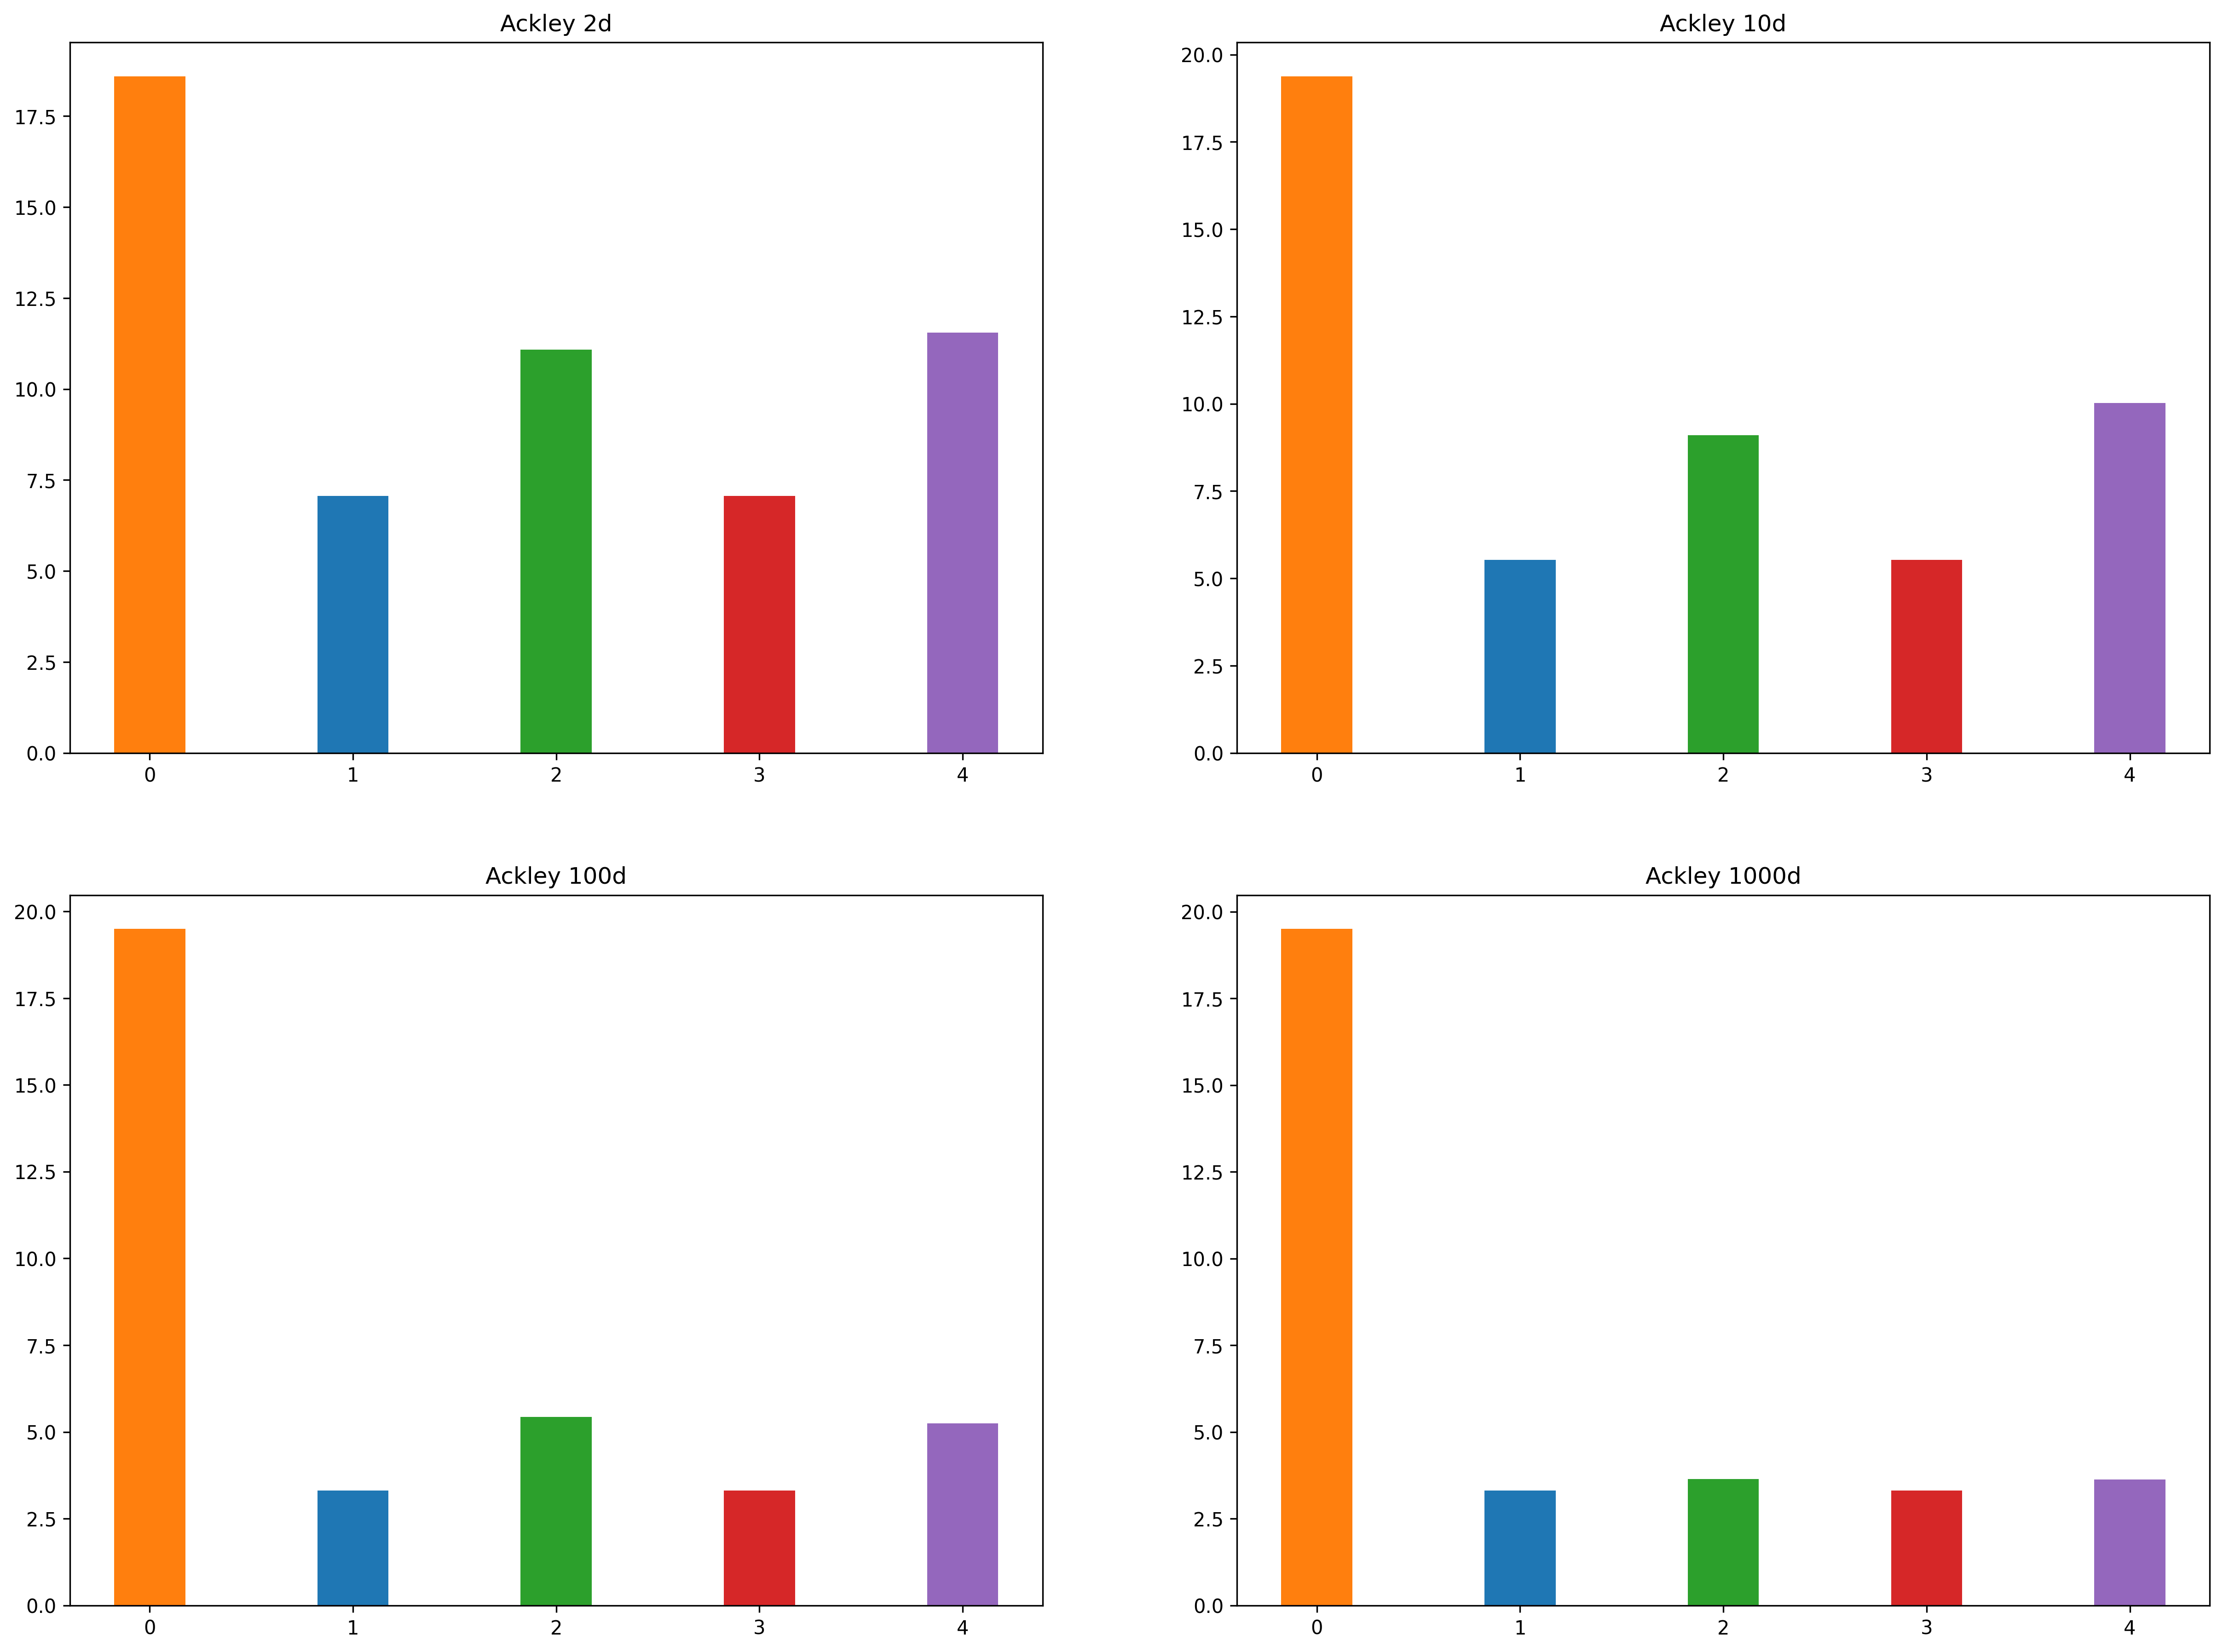

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(20,15), dpi=300)
ax = ax.ravel()
    
for i, d in enumerate(dimensions):
    ax[i].bar(np.arange(5), means[d], 0.35, color=['C1', 'C0', 'C2', 'C3', 'C4'])
    ax[i].set_title(f"Ackley {d}d")